In [1]:
from IPython.core.display import display, HTML
import os

if os.getenv('TITLE') is not None:
    display(HTML('<h1>'+os.getenv('TITLE')+'</h1>'))

/tmp/ipykernel_178457/949785084.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# Load all of the modules
import sys, os

CWD             = os.getcwd()
basepath        = os.path.dirname(CWD)
OS_AMRWINDFEDIR = os.getenv('AMRWINDFEDIR')

# amrwindfedirs = ['../../amr-wind-frontend',
#                  basepath]
# if OS_AMRWINDFEDIR is not None: amrwindedirs.append(OS_AMRWINDFEDIR)
# for x in amrwindfedirs: sys.path.insert(1, x)

import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from scipy.interpolate import RegularGridInterpolator
import math
import copy


In [3]:
# Load ruamel or pyyaml as needed                                                                                                                                                      
try:
    import ruamel.yaml
    yaml = ruamel.yaml.YAML(typ='rt')
    useruamel=True
    loaderkwargs = {}
    dumperkwargs = {}

    Loader=yaml.load
except:
    import yaml as yaml
    print("# Loaded yaml")
    useruamel=False
    loaderkwargs = {}
    dumperkwargs = {'default_flow_style':False }
    Loader=yaml.safe_load

In [4]:
def get_relative_value(y,avg_length_start,avg_length_end):
    y_initial = np.nanmean(y[:avg_length_start])
    y_final = np.nanmean(y[-avg_length_end:])
    y_relative = (y-y_initial)/(y_final-y_initial)
    return y_relative,y_final,y_initial

In [5]:
def simple_rolling_average(data, window_size):
    """
    Calculates the simple rolling average of a 1D NumPy array.

    Args:
        data (np.ndarray): The input 1D NumPy array.
        window_size (int): The size of the moving window.

    Returns:
        np.ndarray: A new array containing the simple rolling averages.
    """
    if not isinstance(data, np.ndarray) or data.ndim != 1:
        raise ValueError(f"Input 'data' must be a 1D NumPy array not array of shape {str(np.shape(data))}")
    if not isinstance(window_size, int) or window_size <= 0:
        raise ValueError("Input 'window_size' must be a positive integer.")
    if window_size > len(data):
        raise ValueError("Window size cannot be larger than the data length.")

    # Create a kernel of ones for the average calculation
    weights = np.ones(window_size) / window_size

    # Convolve the data with the weights to get the rolling average
    rolling_avg = np.convolve(data, weights, mode='same')

    # Handle the edges by padding with NaN or another value
    pad_size = window_size // 2
    rolling_avg[:pad_size] = np.nan  # or use 0 or any other value
    rolling_avg[-pad_size:] = np.nan  # or use 0 or any other value

    return rolling_avg

def extrapolate_ends(x,mean_values_filtered,window_filtered):

    # decimate down to resolution of filtered data
    notnan_i = np.where(~np.isnan(mean_values_filtered))[0]
    notnan_keep_i = notnan_i[::int(window_filtered/2)]
    
    # Use the slopes for extrapolation
    slope_start = (mean_values_filtered[notnan_keep_i[1]]-mean_values_filtered[notnan_keep_i[0]])/(x[notnan_keep_i[1]]-x[notnan_keep_i[0]])
    slope_end = (mean_values_filtered[notnan_keep_i[-1]]-mean_values_filtered[notnan_keep_i[-2]])/(x[notnan_keep_i[-1]]-x[notnan_keep_i[-2]])
    def extrapolate(x_new,mean_values_filtered):
        if x_new < x[notnan_keep_i][0]:  # Before the first valid point
            return mean_values_filtered[notnan_keep_i][0] + slope_start * (x_new - x[notnan_keep_i][0])
        elif x_new > x[notnan_keep_i][-1]:  # After the last valid point
            return mean_values_filtered[notnan_keep_i][-1] + slope_end * (x_new - x[notnan_keep_i][-1])
        else:
            return mean_values_filtered[x_new]
    mean_values_filtered_extrap = np.array([extrapolate(x_new,mean_values_filtered) for x_new in x])

    return mean_values_filtered_extrap

In [6]:
def adjust_color(color, factor):
    """
    Adjusts the brightness of a given color.
    
    Parameters:
    - color: The original color (can be a hex string or RGB tuple).
    - factor: A factor to adjust the brightness (greater than 1 for lighter, 
              between 0 and 1 for darker).
    
    Returns:
    - Adjusted color in hex format.
    """
    # Convert hex to RGB if necessary
    if isinstance(color, str):
        color = mcolors.hex2color(color)
    
    # Adjust the color
    adjusted_color = tuple(min(max(c * factor, 0), 1) for c in color)
    
    # Convert back to hex
    return adjusted_color

In [7]:
OS_WORKDIR = os.getenv('WORKDIR')
if OS_WORKDIR is not None:
    os.chdir(OS_WORKDIR)

In [8]:
# get simulation type
type_sim = os.getenv('TYPE')
if type_sim==None:
    type_sim = 'FASTFARM'

In [9]:
# load parameters
trialname_specifier = os.getenv('TRIALNAME_SPECIFIER')
if trialname_specifier==None:
    trialname_specifier = 'trial_5_10env'
subdirectory = os.getenv('SUBDIRECTORY')
if subdirectory==None:
    subdirectory = '../../RunFiles/SmallFarm/Runs/Group1'
directory = os.getenv('DIRECTORY')
if directory==None:
    directory = '/ascldap/users/kbrown1/tscratch/Reinforcement_Learning/RLControl/windfarm_v0p12p20_1seed_FASTFarm/analysis/Group1'

In [10]:
# save parameters
savefolder = 'figures'
if not os.path.exists(savefolder):
    os.makedirs(savefolder)
savename_base = 'combined'+'_'+trialname_specifier

In [11]:
# get number of environments
if '_1env' in trialname_specifier:
    n_env = 1
elif '_10env' in trialname_specifier:
    n_env = 10
elif '_100env' in trialname_specifier:
    n_env = 100

In [12]:
# processing parameters
## filtering
window = 10 # window for running mean, std dev
window_filtered = 100 # window for running mean of "filtered" version
## convergence
threshold = 0.99 # ratio of final value that is counted as "converged"
avg_length_start = 100 # num of episodes to average start of run to get initial value
avg_length_end = 300 # num of episodes to average end of run to get final value
if '_extralarge' in trialname_specifier:
    xlims = [window, 3250] # xlimits for convergence plots
elif '_large' in trialname_specifier:
    xlims = [window, 2500] # xlimits for convergence plots
elif '_medium' in trialname_specifier:
    xlims = [window, 1500] # xlimits for convergence plots
else:
    xlims = [window, 1000] # xlimits for convergence plots
if '_100env' in trialname_specifier:
    xlims[1] = xlims[1]*5 # xlimits for convergence plots

In [13]:
# plotting
fontsize=22
xscale = 'linear' # 'linear' 'log'
colors = [(0.25,0.25,0.25),(0.75,0.75,0.75),(167/256, 199/256, 231/256),(171/256,55/256,46/256),(208/256,136/256,33/256),(0.2, 0.5, 0.8)] # varies by trial number
linestyle=['-','--','-.'] # varies by Seedset number
pairlabel = os.getenv('PAIRLABEL')
if pairlabel==None:
    pairlabel = [] # $n_{env}=1$
if '1seed' in directory:
    Pref_label = 'P_{ref,0}'
    Pstochastic_column = 'power_floris_opt_stochastic_1seed'
else:
    Pref_label = 'P_{ref,1}'
    Pstochastic_column = 'power_floris_opt_stochastic'

In [14]:
caselist = []      

if 'trial_3' in trialname_specifier:
    casename = 'Case 0'
    color = colors[3]

elif 'trial_4' in trialname_specifier:
    casename = 'Case 1'
    color = colors[4]

elif 'trial_5' in trialname_specifier:
    casename = 'Case 2'
    color = colors[5]

elif 'trial_6' in trialname_specifier:
    casename = 'Case 3'
    color = colors[5]

if type_sim=='FLORIS':
    basedir = subdirectory+'/sac_post_generate_sequence/trials'

    caselist.append({'label': 'Seedset 1',
                    'name':trialname_specifier+'_1'+'_1',
                    'rundir':basedir,
                    'color':adjust_color(color,1),
                    'linestyle':linestyle[0]})   

    caselist.append({'label': 'Seedset 2',
                    'name':trialname_specifier+'_2'+'_1',
                    'rundir':basedir,
                    'color':adjust_color(color,1.2),
                    'linestyle':linestyle[1]})   

    caselist.append({'label': 'Seedset 3',
                    'name':trialname_specifier+'_3'+'_1',
                    'rundir':basedir,
                    'color':adjust_color(color,1.4),
                    'linestyle':linestyle[2]})    
elif type_sim=='FASTFARM':
    if 'Group1' in subdirectory:
        
        caselist.append({'label': 'Seedset 1, Yaw config. 0',
                        'name':trialname_specifier+'_1'+'_1',
                        'rundir':subdirectory+'/Seed4/yawseeds1/sac_output/trials',
                        'color':adjust_color(color,1),
                        'linestyle':linestyle[0]})   

        caselist.append({'label': 'Seedset 2, Yaw config. 0',
                        'name':trialname_specifier+'_1'+'_1',
                        'rundir':subdirectory+'/Seed5/yawseeds1/sac_output/trials',
                        'color':adjust_color(color,1.2),
                        'linestyle':linestyle[1]})   

        caselist.append({'label': 'Seedset 3, Yaw config. 0',
                        'name':trialname_specifier+'_1'+'_1',
                        'rundir':subdirectory+'/Seed6/yawseeds1/sac_output/trials',
                        'color':adjust_color(color,1.4),
                        'linestyle':linestyle[2]})   
        
    elif 'Group2' in subdirectory:

        caselist.append({'label': 'Seedset 1, Yaw config. 1',
                        'name':trialname_specifier+'_1'+'_1',
                        'rundir':subdirectory+'/Seed4/yawseeds1/sac_output/trials',
                        'color':adjust_color(color,0.4),
                        'linestyle':linestyle[0]})   

        caselist.append({'label': 'Seedset 2, Yaw config. 1',
                        'name':trialname_specifier+'_1'+'_1',
                        'rundir':subdirectory+'/Seed5/yawseeds1/sac_output/trials',
                        'color':adjust_color(color,0.6),
                        'linestyle':linestyle[1]})   

        caselist.append({'label': 'Seedset 3, Yaw config. 1',
                        'name':trialname_specifier+'_1'+'_1',
                        'rundir':subdirectory+'/Seed6/yawseeds1/sac_output/trials',
                        'color':adjust_color(color,0.8),
                        'linestyle':linestyle[2]})   
        
        caselist.append({'label': 'Seedset 1, Yaw config. 2',
                        'name':trialname_specifier+'_1'+'_1',
                        'rundir':subdirectory+'/Seed4/yawseeds2/sac_output/trials',
                        'color':adjust_color(color,1),
                        'linestyle':linestyle[0]})   

        caselist.append({'label': 'Seedset 2, Yaw config. 2',
                        'name':trialname_specifier+'_1'+'_1',
                        'rundir':subdirectory+'/Seed5/yawseeds2/sac_output/trials',
                        'color':adjust_color(color,1.2),
                        'linestyle':linestyle[1]})   

        caselist.append({'label': 'Seedset 3, Yaw config. 2',
                        'name':trialname_specifier+'_1'+'_1',
                        'rundir':subdirectory+'/Seed6/yawseeds2/sac_output/trials',
                        'color':adjust_color(color,1.4),
                        'linestyle':linestyle[2]}) 

        caselist.append({'label': 'Seedset 1, Yaw config. 3',
                        'name':trialname_specifier+'_1'+'_1',
                        'rundir':subdirectory+'/Seed4/yawseeds3/sac_output/trials',
                        'color':adjust_color(color,1.6),
                        'linestyle':linestyle[0]})   

        caselist.append({'label': 'Seedset 2, Yaw config. 3',
                        'name':trialname_specifier+'_1'+'_1',
                        'rundir':subdirectory+'/Seed5/yawseeds3/sac_output/trials',
                        'color':adjust_color(color,1.8),
                        'linestyle':linestyle[1]})   

        caselist.append({'label': 'Seedset 3, Yaw config. 3',
                        'name':trialname_specifier+'_1'+'_1',
                        'rundir':subdirectory+'/Seed6/yawseeds3/sac_output/trials',
                        'color':adjust_color(color,2.0),
                        'linestyle':linestyle[2]})   

In [15]:
datafilename = 'monitor.csv'
datafilename_WithDEL = 'monitor_withDEL.csv'

DEL_list = ['RotTorq_[kN-m]', 'RootMxc1_[kN-m]', 'RootMyc1_[kN-m]', 'RootMzc1_[kN-m]', 'TwrBsMxt_[kN-m]', 'TwrBsMyt_[kN-m]', 'TwrBsMzt_[kN-m]', 'YawBrMxn_[kN-m]', 'YawBrMyn_[kN-m]', 'YawBrMzn_[kN-m]']
DEL_list_names = ['RotTorq', 'RootMxc1', 'RootMyc1', 'RootMzc1', 'TwrBsMxt', 'TwrBsMyt', 'TwrBsMzt', 'YawBrMxn', 'YawBrMyn', 'YawBrMzn']

In [16]:
# Define the converter function
def string_to_float(x):
    try:
        return float(x)
    except ValueError:
        return x


In [17]:
# remove cases that do not exist
print(len(caselist))
i = 0
while i < len(caselist):
    case = caselist[i]
    filepath = os.path.join(case['rundir'], case['name'], datafilename_WithDEL)
    if not os.path.exists(filepath):
        filepath = os.path.join(case['rundir'], case['name'], datafilename)
        if not os.path.exists(filepath):
            caselist.pop(i)
        else:
            i += 1
            case['datafilename'] = datafilename
    else:
        i += 1
        case['datafilename'] = datafilename_WithDEL
print(len(caselist))


3
3


In [18]:
# load data
for i, case in enumerate(caselist):
    filepath = os.path.join(case['rundir'],case['name'],case['datafilename'])
    case['data'] = pd.read_csv(filepath,header=1)

    # this column has bad data
    if 'DEL' in case['data']:
        case['data'].drop('DEL',axis=1,inplace=True)

    # set true reward signal since logging did not have correct value for "r"
    if '1seed' in directory:
        case['data']['r'] = case['data']['r_stochastic_1seed']
    else:
        case['data']['r'] = case['data']['r_stochastic']

    if i==0:
        print(case['data'].keys())

Index(['r', 'l', 't', 'r.1', 'r_stochastic', 'r_stochastic_1seed', 'power',
       'power_floris_opt_stochastic', 'power_floris_opt', 'yaw_angles_actual',
       'yaw_angles', 'yaw_angles_floris_opt', 'rel_yaw_angles_actual',
       'rel_yaw_angles', 'rel_yaw_angles_floris_opt', 'wind_dir', 'wind_spd',
       'turb_int'],
      dtype='object')


In [19]:
## Convergence study

In [20]:
# add Turbine_ID
for i, case in enumerate(caselist):

    # Loop through the columns and convert strings to float arrays
    for column in case['data'].columns:
        if isinstance(case['data'][column][0],str):
            for j in range(len(case['data'][column])):
                numbers = case['data'][column][j].replace(",", "").replace("[", "").replace("]", "").replace("(", "").replace(")", "").split() # hack to get rid of apostrophes and brackets in the string
                case['data'].at[j,column] = [float(num) for num in numbers]
                
    # calculate moving average and std dev and maxes/mins
    ## Power (reward)
    r_series = pd.Series(case['data']['r']) # Create a pandas Series from the 'r' values
    case['data']['r_movingavg'] = r_series.rolling(window=window).mean() # Calculate the moving average
    case['data']['r_movingstd'] = r_series.rolling(window=window).std() # Calculate the moving standard deviation
    case['data']['r_movingmax'] = r_series.rolling(window=window).max() # Calculate the moving max
    case['data']['r_movingmin'] = r_series.rolling(window=window).min() # Calculate the moving min
    if 'r_stochastic' in case['data']:
        r_series = pd.Series(case['data']['r_stochastic']) # Create a pandas Series from the 'r_stochastic' values
        case['data']['r_stochastic_movingavg'] = r_series.rolling(window=window).mean() # Calculate the moving average
        case['data']['r_stochastic_movingstd'] = r_series.rolling(window=window).std() # Calculate the moving standard deviation
        case['data']['r_stochastic_movingmax'] = r_series.rolling(window=window).max() # Calculate the moving max
        case['data']['r_stochastic_movingmin'] = r_series.rolling(window=window).min() # Calculate the moving min
    else:
        case['data']['r_stochastic_movingavg'] = [np.nan]*len(case['data']['r'])
        case['data']['r_stochastic_movingstd'] = [np.nan]*len(case['data']['r'])
        case['data']['r_stochastic_movingmax'] = [np.nan]*len(case['data']['r'])
        case['data']['r_stochastic_movingmin'] = [np.nan]*len(case['data']['r'])

    ## DEL
    if DEL_list[0] in case['data']:
        df = pd.DataFrame([case['data'][DEL_list_indiv] for DEL_list_indiv in DEL_list])
        df = case['data'][DEL_list]
        df.columns=DEL_list_names
        for column in df.columns:
            case['data'][column+'_movingavg'] = [None] * len(df)
            case['data'][column+'_movingavg'] = df[column].rolling(window=window).mean() # Calculate the moving average
            case['data'][column+'_movingstd'] = [None] * len(df)
            case['data'][column+'_movingstd'] = df[column].rolling(window=window).std() # Calculate the moving std
            case['data'][column+'_movingmax'] = [None] * len(df)
            case['data'][column+'_movingmax'] = df[column].rolling(window=window).max() # Calculate the moving max
            case['data'][column+'_movingmin'] = [None] * len(df)
            case['data'][column+'_movingmin'] = df[column].rolling(window=window).min() # Calculate the moving min

    ## Yaw
    if 'rel_yaw_angles' in case['data']:
        df = pd.DataFrame(case['data']['rel_yaw_angles'].tolist())
        num_turbines=len(df.iloc[0])
        df.columns=['rel_yaw_angle'+str(j) for j in range(num_turbines)]
        for column in df.columns:
            case['data'][column+'_movingavg'] = [None] * len(df)
            case['data'][column+'_movingavg'] = df[column].rolling(window=window).mean() # Calculate the moving average
            case['data'][column+'_movingstd'] = [None] * len(df)
            case['data'][column+'_movingstd'] = df[column].rolling(window=window).std() # Calculate the moving std
            case['data'][column+'_movingmax'] = [None] * len(df)
            case['data'][column+'_movingmax'] = df[column].rolling(window=window).max() # Calculate the moving max
            case['data'][column+'_movingmin'] = [None] * len(df)
            case['data'][column+'_movingmin'] = df[column].rolling(window=window).min() # Calculate the moving min

/tmp/ipykernel_178457/1406971794.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  case['data'][column+'_movingavg'] = [None] * len(df)
/tmp/ipykernel_178457/1406971794.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  case['data'][column+'_movingstd'] = [None] * len(df)
/tmp/ipykernel_178457/1406971794.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

In [21]:
# reduce length of data to match plotted window (so that calculation of avg_length later will be consistent with the plotted data)
for i, case in enumerate(caselist):
    index_keep = np.where(case['data'].index<xlims[1])[0]
    case['data'] = case['data'].iloc[index_keep]

In [22]:
# plotting setup
plt.rc('font', size=fontsize)


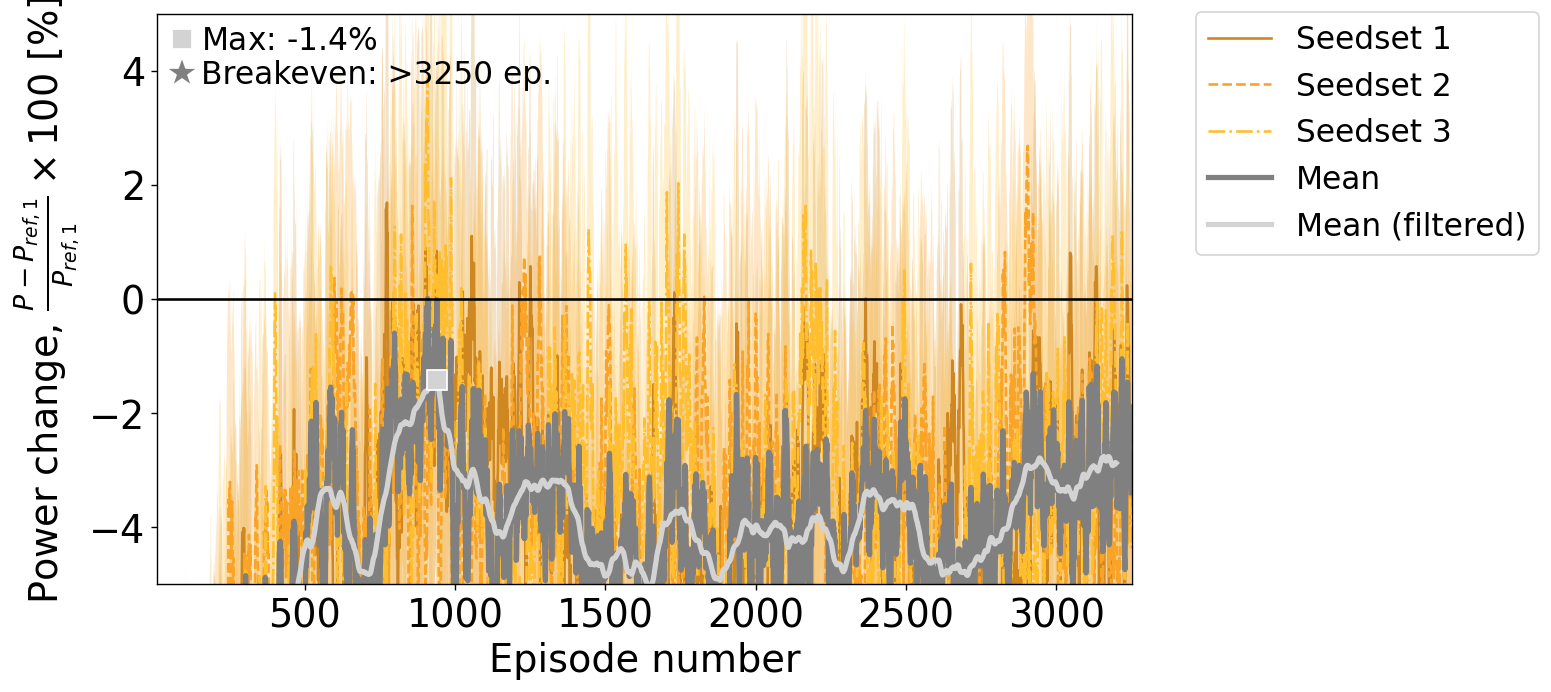

In [23]:
# plot convergence of reward
fig=plt.figure(figsize=(10,6),dpi=125)
for case in caselist:
    # plot history
    keepEvery = 1
    x = case['data'].index[::keepEvery]
    y = case['data']['r_movingavg'][::keepEvery]
    error_low = case['data']['r_movingstd'][::keepEvery]
    error_high = case['data']['r_movingstd'][::keepEvery]
    # error_low = case['data']['r_movingmin'][::keepEvery]-case['data']['r_movingavg'][::keepEvery]
    # error_high = case['data']['r_movingmax'][::keepEvery]-case['data']['r_movingavg'][::keepEvery]
    if pairlabel and pairlabel in case['label']:
        plt.plot(x,y, color=case['color'], ls = case['linestyle'])
    else:
        plt.plot(x,y, color=case['color'], label=case['label'], ls = case['linestyle'])
    plt.fill_between(x, y-error_low, y+error_high, color=case['color'], ls = case['linestyle'], alpha=0.25, edgecolor='None')

# Calculate and plot the mean lines
mean_time = np.mean([case['data']['t'][::keepEvery] for case in caselist],axis=0)
mean_values = np.mean([case['data']['r_movingavg'][::keepEvery] for case in caselist],axis=0)
mean_values_filtered = simple_rolling_average(mean_values,window_filtered)
# mean_values_filtered_extrap = extrapolate_ends(x,mean_values_filtered,window_filtered)
plt.plot(x, mean_values, color='gray', linewidth=3, label='Mean', linestyle='-')
plt.plot(x, mean_values_filtered, color='lightgray', linewidth=3, label='Mean (filtered)', linestyle='-')

# Record max filtered value
mean_values_filtered_max_i = np.nanargmax(mean_values_filtered)
mean_values_filtered_max = np.nanmax(mean_values_filtered)
plt.plot(0.025,0.955,transform=fig.gca().transAxes, color='lightgray', markeredgecolor='white', ls = 'None', marker='s', markersize=12)
plt.text(0.025+0.02,0.925,'Max: '+f"{mean_values_filtered_max:.1f}"+'$\%$',transform=fig.gca().transAxes,fontsize=fontsize-4, color='black', ha='left', va='bottom')
plt.plot(x[mean_values_filtered_max_i],mean_values_filtered[mean_values_filtered_max_i], color='lightgray', markeredgecolor='white', ls = 'None', marker='s', markersize=12) # , label='Mean (filtered) maximum: '+f"{np.nanmax(mean_values_filtered_extrap):.1f}"+'$\%$')

# Add threshold marker for the mean (filtered) line
y_relative,_,_ = get_relative_value(mean_values_filtered,avg_length_start,avg_length_end)
threshold_i = np.where(y_relative>threshold)[0][0] # episode number when threshold is first reached
threshold_value = mean_values_filtered[threshold_i]
threshold_time = mean_time[threshold_i]/60 # time in minutes
# plt.plot(threshold_i,threshold_value, color='gray', markeredgecolor='white', ls = 'None', marker='*', markersize=15, label=r"99% of total rise")

# Add breakeven marker for the mean (filtered) line
mean_values_extrap = np.interp(x,x[~np.isnan(mean_values)],mean_values[~np.isnan(mean_values)]) # fill in NaNs at beginning and end with nearest neighbor
y_cumsum = np.nancumsum(mean_values_extrap)
if np.max(y_cumsum)>0:
    breakeven_i = np.where((y_cumsum[:-1] < 0) & (y_cumsum[1:] >= 0))[0][-1] # episode number when breakeven turns positive for the last time
    breakeven_value = mean_values_extrap[breakeven_i]
    breakeven_time = mean_time[breakeven_i]/60 # time in minutes
    plt.plot(breakeven_i,breakeven_value, color='gray', markeredgecolor='white', ls = 'None', marker='*', markersize=17) # , label='Mean (filtered) breakeven: '+f"{breakeven_i:.0f}"+' ep.'
    breakeven_text = 'Breakeven: '+f"{breakeven_i:.0f}"+' ep.'
else:
    breakeven_i = np.nan
    breakeven_time = np.nan
    breakeven_text = 'Breakeven: >'+str(xlims[1])+' ep.'
plt.plot(0.025,0.895,transform=fig.gca().transAxes, color='gray', markeredgecolor='white', ls = 'None', marker='*', markersize=19)
plt.text(0.025+0.02,0.865,breakeven_text,transform=fig.gca().transAxes,fontsize=fontsize-4, color='black', ha='left', va='bottom')

plt.xscale(xscale)
plt.axhline(0, color='black', linestyle='-')
plt.xlabel('Episode number')
plt.ylabel(rf'Power change, $\frac{{P-{Pref_label}}}{{{Pref_label}}} \times 100$ [$\%$]')
plt.xlim(xlims)
plt.ylim([-5, 5])
plt.legend(fontsize=fontsize-4, loc='lower right')
plt.gcf().set_size_inches(9, 6)
plt.tight_layout()
fig.savefig(os.path.join(savefolder,savename_base+'_'+'reward_convergence.svg'), format='svg', dpi=100)
plt.gcf().set_size_inches(13, 6)
plt.legend(fontsize=fontsize-4,bbox_to_anchor=(1.05, 1.03))
plt.tight_layout()
fig.savefig(os.path.join(savefolder,savename_base+'_'+'reward_convergence_legendoutside.svg'), format='svg', dpi=100)


In [24]:
# print tables
print('Threshold Efficiency', end=' ')
print(r'\\')
print("{:.2f}".format(threshold_i)+' & ', end=' ')
print(r'\\')

print('Threshold Speed', end=' ')
print(r'\\')
print("{:.2f}".format(threshold_i/n_env)+' & ', end=' ')
print(r'\\')

print('Breakeven Efficiency', end=' ')
print(r'\\')
print("{:.2f}".format(breakeven_i)+' & ', end=' ')
print(r'\\')

print('Breakeven Speed', end=' ')
print(r'\\')
print("{:.2f}".format(breakeven_i/n_env)+' & ', end=' ')
print(r'\\')


Threshold Efficiency \\
777.00 &  \\
Threshold Speed \\
77.70 &  \\
Breakeven Efficiency \\
nan &  \\
Breakeven Speed \\
nan &  \\


In [25]:
# plot convergence of DEL
if DEL_list[0] in case['data']:
    for DEL_list_names_i,DEL_list_names_indiv in enumerate(DEL_list_names):
        fig=plt.figure(figsize=(10,6),dpi=125)
        for case in caselist:
            # plot history
            keepEvery = 1
            x = case['data'].index[::keepEvery]
            y = case['data'][DEL_list_names_indiv+'_movingavg'][::keepEvery]
            error_low = case['data'][DEL_list_names_indiv+'_movingstd'][::keepEvery]
            error_high = case['data'][DEL_list_names_indiv+'_movingstd'][::keepEvery]
            # error_low = case['data']['r_movingmin'][::keepEvery]-case['data']['r_movingavg'][::keepEvery]
            # error_high = case['data']['r_movingmax'][::keepEvery]-case['data']['r_movingavg'][::keepEvery]
            if pairlabel and pairlabel in case['label']:
                plt.plot(x,y, color=case['color'], ls = case['linestyle'])
            else:
                plt.plot(x,y, color=case['color'], label=case['label'], ls = case['linestyle'])
            plt.fill_between(x, y-error_low, y+error_high, color=case['color'], ls = case['linestyle'], alpha=0.25, edgecolor='None')

        # Calculate and plot the mean lines
        mean_time = np.mean([case['data']['t'][::keepEvery] for case in caselist],axis=0)
        mean_values = np.mean([case['data'][DEL_list_names_indiv+'_movingavg'][::keepEvery] for case in caselist],axis=0)
        mean_values_filtered = simple_rolling_average(mean_values,window_filtered)
        plt.plot(x, mean_values, color=(0.7, 0.7, 0.7), linewidth=3, label='Mean', linestyle='-')
        plt.plot(x, mean_values_filtered, color='lightgray', linewidth=3, label='Mean (filtered)', linestyle='-')

        # Record max filtered value
        mean_values_filtered_max_i = np.nanargmax(mean_values_filtered)
        plt.plot(x[mean_values_filtered_max_i],mean_values_filtered[mean_values_filtered_max_i], color='lightgray', markeredgecolor='white', ls = 'None', marker='s', markersize=12, label='Mean (filtered) maximum: '+f"{np.nanmax(mean_values_filtered):.1f}"+'$\%$')
        # plt.text(0.025,0.025,"Max increase: "+f"{np.nanmax(mean_values_filtered):.1f}"+'$\%$',transform=fig.gca().transAxes,fontsize=fontsize-2, color='black', ha='left', va='bottom')

        plt.xscale(xscale)
        plt.axhline(0, color='black', linestyle='-')
        plt.xlabel('Episode number')
        plt.ylabel(r'Flap DEL change, $\frac{D-D_{\text{ref}}}{D_{\text{ref}}} \times 100$ [$\%$]')
        plt.xlim(xlims)
        plt.ylim([-20, 20])
        plt.legend(fontsize=fontsize-4, loc='lower right')
        plt.gcf().set_size_inches(9, 6)
        plt.tight_layout()
        fig.savefig(os.path.join(savefolder,savename_base+'_'+'del_'+DEL_list_names_indiv+'_convergence.svg'), format='svg', dpi=100)
        plt.gcf().set_size_inches(13, 6)
        plt.legend(fontsize=fontsize-4,bbox_to_anchor=(1.05, 1.03))
        plt.tight_layout()
        fig.savefig(os.path.join(savefolder,savename_base+'_'+'del_'+DEL_list_names_indiv+'_convergence_legendoutside.svg'), format='svg', dpi=100)


/tmp/ipykernel_178457/1365302737.py:56: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


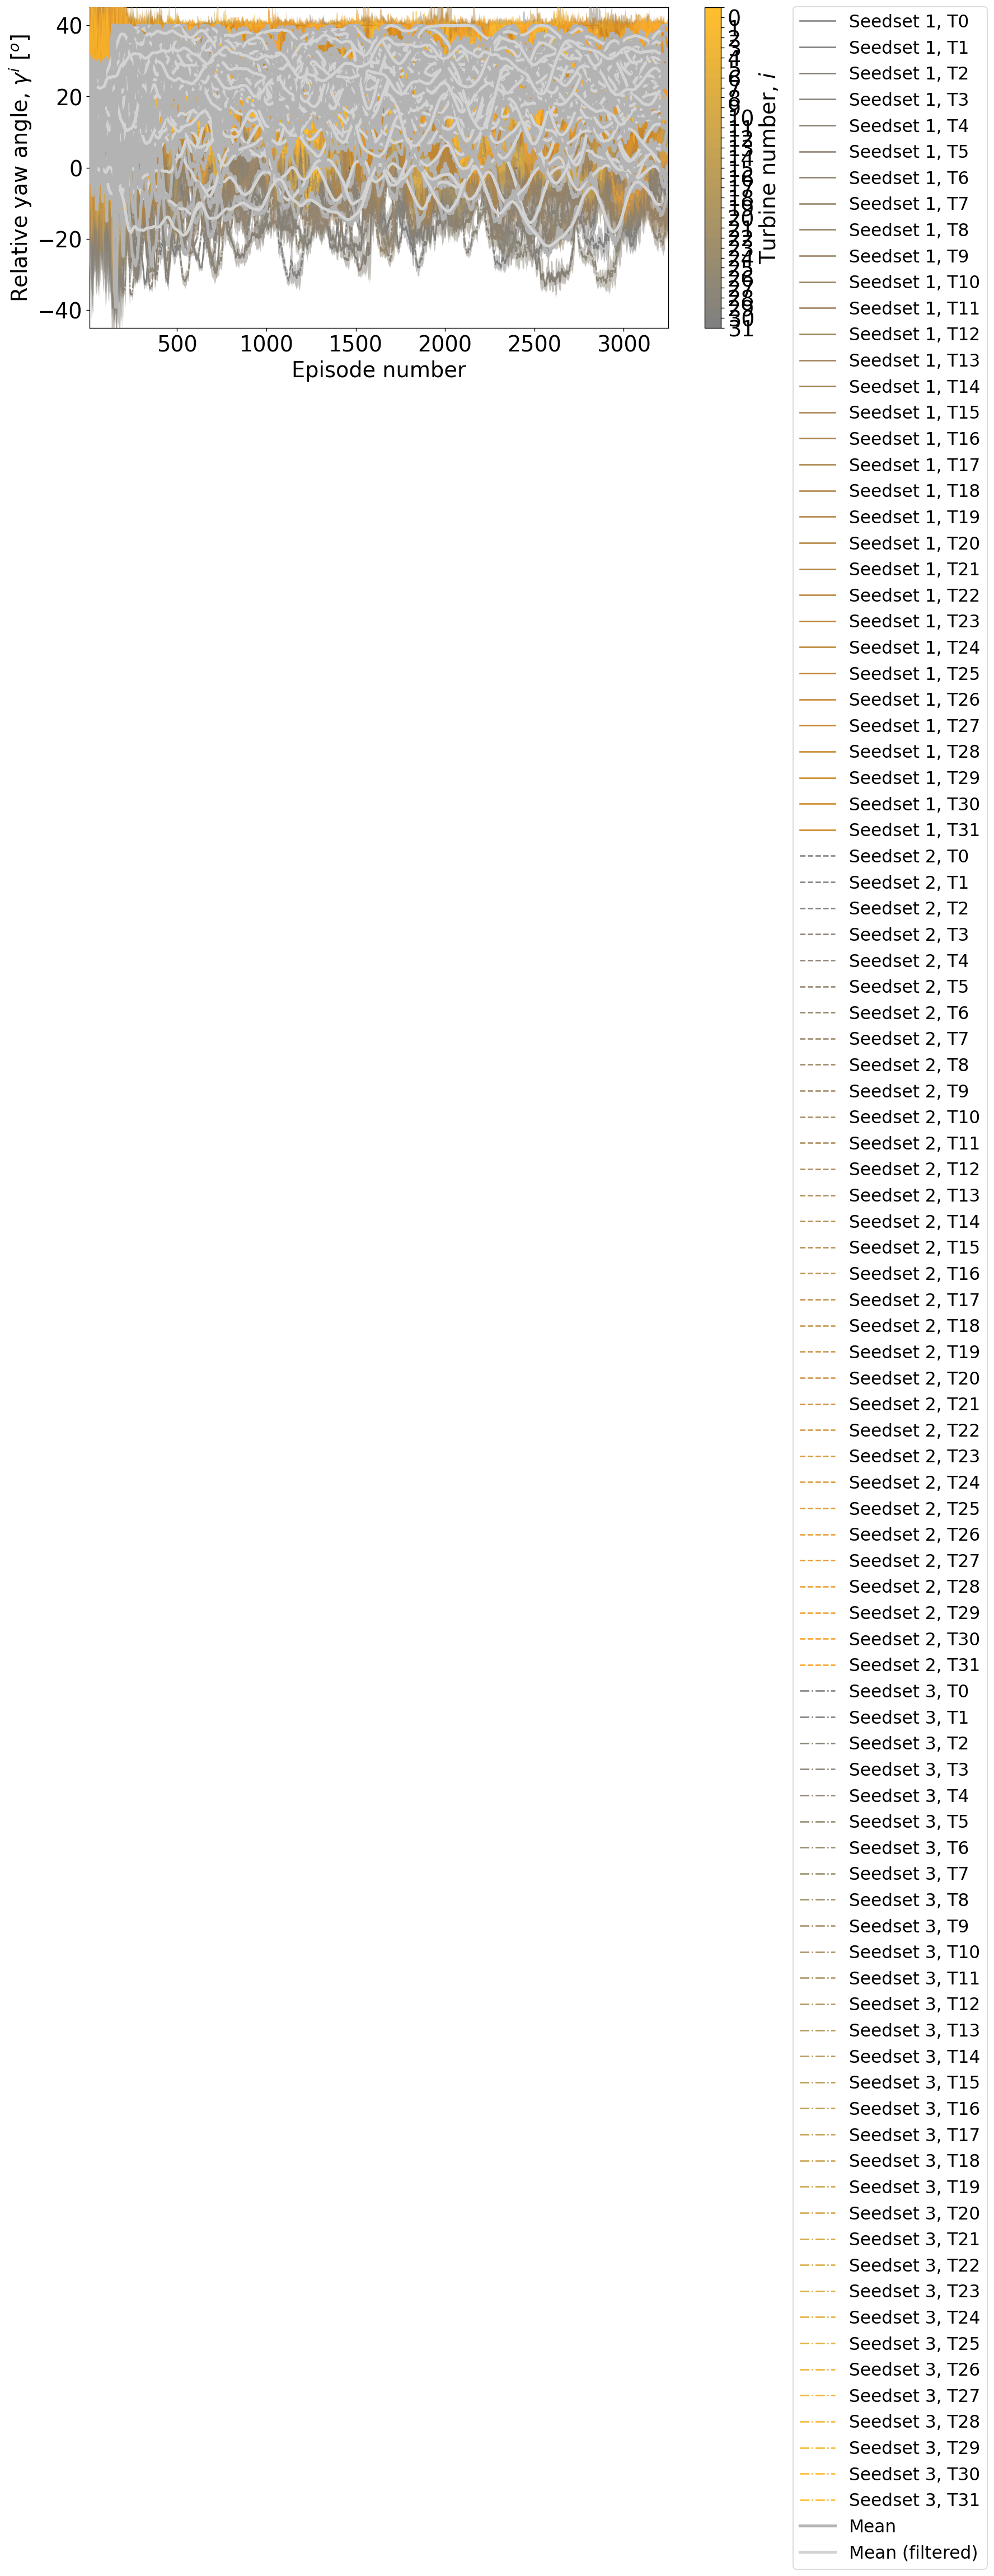

In [26]:
# plot convergence of yaw angles
fig=plt.figure(figsize=(10,6),dpi=125)
for case in caselist:
    for i in range(num_turbines):
        keepEvery = 1
        x = case['data'].index[::keepEvery]
        y = case['data']['rel_yaw_angle'+str(i)+'_movingavg'][::keepEvery]
        error = case['data']['rel_yaw_angle'+str(i)+'_movingstd'][::keepEvery]
        color = case['color']
        color1 = (0.5, 0.5, 0.5)
        color2 = case['color']
        blend_factor = i / (num_turbines - 1)  # Normalized between 0 and 1
        blended_color = (
        color1[0] * (1 - blend_factor) + color2[0] * blend_factor,
        color1[1] * (1 - blend_factor) + color2[1] * blend_factor,
        color1[2] * (1 - blend_factor) + color2[2] * blend_factor)
        plt.plot(x,y, color=blended_color, label=case['label']+', T'+str(i), alpha=1, ls = case['linestyle'],zorder=2*i)
        plt.fill_between(x, y-error, y+error, color=blended_color, ls = case['linestyle'], alpha=0.5, edgecolor='None',zorder=2*i+1)

# Calculate and plot the mean lines
for i in range(num_turbines):
    mean_time = np.mean([case['data']['t'][::keepEvery] for case in caselist],axis=0)
    mean_values = np.mean([case['data']['rel_yaw_angle'+str(i)+'_movingavg'][::keepEvery] for case in caselist],axis=0)
    mean_values_filtered = simple_rolling_average(mean_values,window_filtered)
    if i==0:
        plt.plot(x, mean_values, color=(0.7, 0.7, 0.7), linewidth=3, label='Mean', linestyle='-',zorder=2000*i+1)
        plt.plot(x, mean_values_filtered, color='lightgray', linewidth=3, label='Mean (filtered)', linestyle='-',zorder=2000*i+2)
    else:
        plt.plot(x, mean_values, color=(0.7, 0.7, 0.7), linewidth=3, linestyle='-',zorder=2000*i+1)
        plt.plot(x, mean_values_filtered, color='lightgray', linewidth=3, linestyle='-',zorder=2000*i+2)

# Create a colormap from color1 to color2
num_ticks = num_turbines
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', [color1, color2], N=num_ticks)
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax = fig.gca(), orientation='vertical')
cbar.ax.set_position([0.1, 0.1, 0.2, 0.4])  # [left, bottom, width, height]
ticks = np.linspace(0, 1, num_ticks+1)  # Generate ticks from 0 to 1
cbar.set_ticks(ticks)  # Set the ticks on the colorbar
tick_labels = [''] + [str(i) for i in range(num_ticks)]  # Add empty strings
tick_labels = list(reversed(tick_labels))
cbar.set_ticklabels(tick_labels)  # Set the tick labels
cbar.set_label('Turbine number, $i$')

plt.xscale(xscale)
plt.axhline(0, color='black', linestyle='-')
plt.xlabel('Episode number')
plt.ylabel('Relative yaw angle, $\gamma^i$ [$^{o}$]')
plt.xlim(xlims)
plt.ylim([-45, 45])
plt.gcf().set_size_inches(9, 6)
# plt.legend(fontsize=fontsize-4)
plt.tight_layout()
fig.savefig(os.path.join(savefolder,savename_base+'_'+'yaw_convergence.svg'), format='svg', dpi=100)
plt.gcf().set_size_inches(13, 6)
plt.legend(fontsize=fontsize-4,bbox_to_anchor=(1.2, 1.03))
plt.tight_layout()
fig.savefig(os.path.join(savefolder,savename_base+'_'+'yaw_convergence_legendoutside.svg'), format='svg', dpi=100)

In [27]:
# save case data
savename = os.path.join(savefolder,savename_base+'_'+'data.pkl')
with open(savename, 'wb') as file:
    pickle.dump(caselist, file)

# save mean threshold data
savename = os.path.join(savefolder,savename_base+'_'+'threshold.pkl')
with open(savename, 'wb') as file:
    pickle.dump((threshold_i,threshold_time), file)

# save mean breakeven data
savename = os.path.join(savefolder,savename_base+'_'+'breakeven.pkl')
with open(savename, 'wb') as file:
    pickle.dump((breakeven_i,breakeven_time), file)

In [28]:
## Detailed analysis of converged results

/tmp/ipykernel_178457/4186995868.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  case['data']['power_'+str(j)] = [case['data']['power'].iloc[index][j] for index in range(len(case['data']))]
/tmp/ipykernel_178457/4186995868.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  case['data'][Pstochastic_column+'_'+str(j)] = [case['data'][Pstochastic_column].iloc[index][j] for index in range(len(case['data']))]
/tmp/ipykernel_178457/4186995868.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

Max difference in recalculated reward vs. original reward for case 0: 1.5594059377121994e-10


/tmp/ipykernel_178457/4186995868.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  case['data']['power_'+str(j)] = [case['data']['power'].iloc[index][j] for index in range(len(case['data']))]
/tmp/ipykernel_178457/4186995868.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  case['data'][Pstochastic_column+'_'+str(j)] = [case['data'][Pstochastic_column].iloc[index][j] for index in range(len(case['data']))]
/tmp/ipykernel_178457/4186995868.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

Max difference in recalculated reward vs. original reward for case 1: 1.4828005490130636e-10


/tmp/ipykernel_178457/4186995868.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  case['data']['power_'+str(j)] = [case['data']['power'].iloc[index][j] for index in range(len(case['data']))]
/tmp/ipykernel_178457/4186995868.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  case['data'][Pstochastic_column+'_'+str(j)] = [case['data'][Pstochastic_column].iloc[index][j] for index in range(len(case['data']))]
/tmp/ipykernel_178457/4186995868.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

Max difference in recalculated reward vs. original reward for case 2: 1.3791279229735665e-10


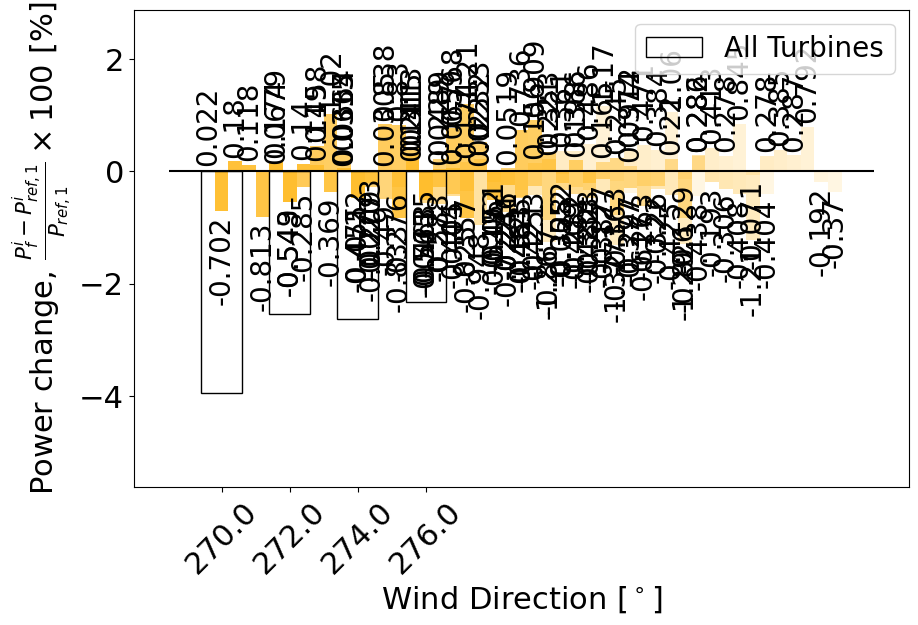

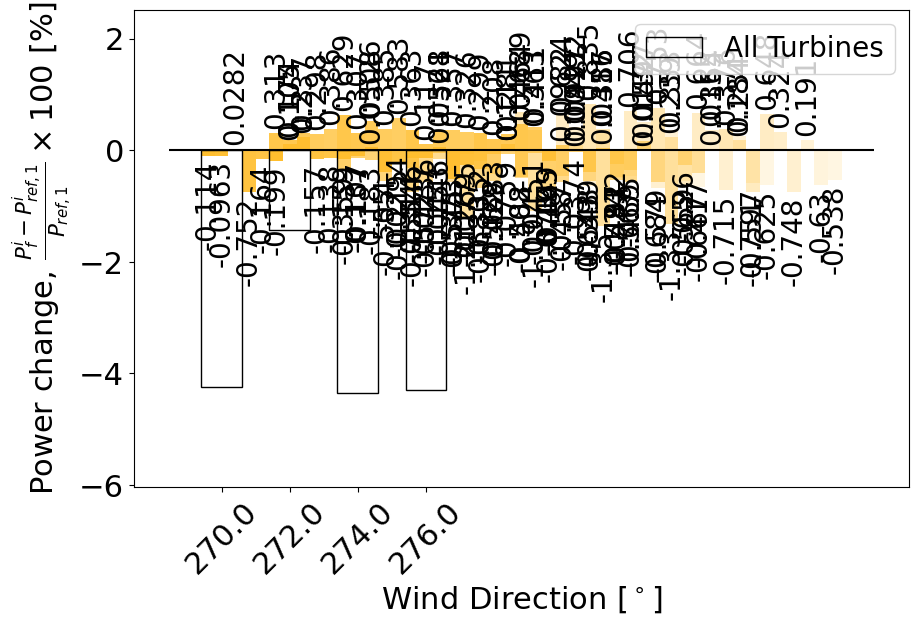

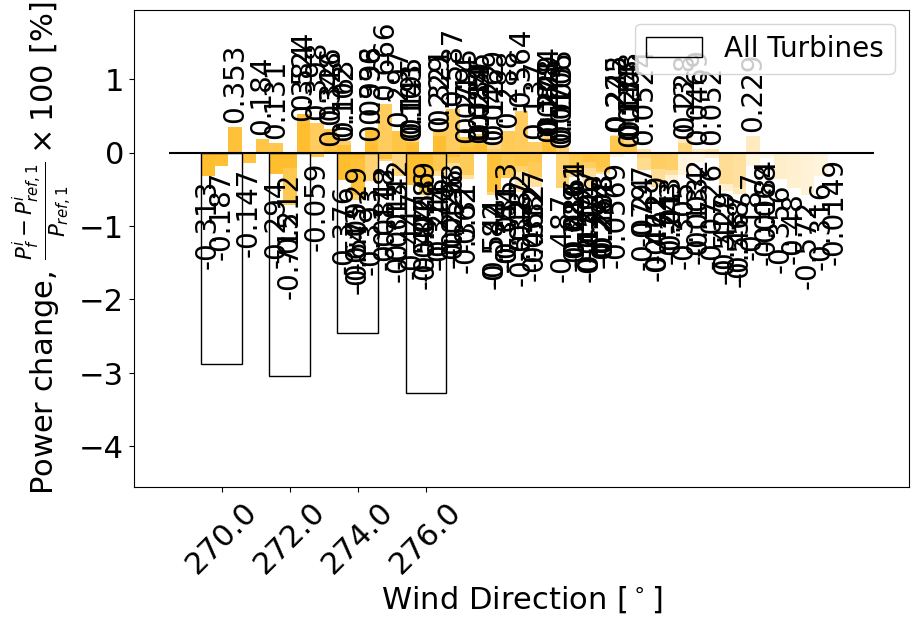

In [29]:
# add QoIs
groupby = ['wind_dir']
if Pstochastic_column in case['data']: # this is needed to avoid errors for FLORIS cases, which don't have this variable
    for i, case in enumerate(caselist):

        # expand the power into individual columns
        for j in range(len(case['data']['power'][0])):
            case['data']['power_'+str(j)] = [case['data']['power'].iloc[index][j] for index in range(len(case['data']))]
            case['data'][Pstochastic_column+'_'+str(j)] = [case['data'][Pstochastic_column].iloc[index][j] for index in range(len(case['data']))]  
        case['data']['power_sum'] = [np.sum(case['data']['power'][index]) for index in range(len(case['data']))]   # recalculate power total since previous calculations of reward are normalized
        case['data'][Pstochastic_column+'_sum'] = [np.sum(case['data'][Pstochastic_column][index]) for index in range(len(case['data']))]   # recalculate power total since previous calculations of reward are normalized

        # normalize on FLORIS optimal
        case['data']['r_recalculated'] = (case['data']['power_sum'] - case['data'][Pstochastic_column+'_sum'])/case['data'][Pstochastic_column+'_sum']*100
        for j in range(len(case['data']['power'][0])):
            case['data']['r_recalculated_'+str(j)] = (case['data']['power_'+str(j)] - case['data'][Pstochastic_column+'_'+str(j)])/case['data'][Pstochastic_column+'_sum']*100 #/case['data'][Pstochastic_column+'_'+str(j)]*100
        
        # check that recalculation is consistent with original
        diff = case['data']['r_recalculated'] - case['data']['r']
        max_diff = np.max(np.abs(diff))
        print('Max difference in recalculated reward vs. original reward for case '+str(i)+ ': '+str(max_diff))

        # group
        case['grouped1'] = case['data'].iloc[-avg_length_end:].groupby(by=groupby,as_index=False)['r_recalculated'].mean()
        case['grouped1_indiv'] = [[] for _ in range(len(case['data']['power'][0]))]
        for j in range(len(case['data']['power'][0])):
            case['grouped1_indiv'][j] = case['data'].iloc[-avg_length_end:].groupby(by=groupby,as_index=False)['r_recalculated_'+str(j)].mean()

        ### plot
        values = case['grouped1']
        values_indiv = case['grouped1_indiv']

        # Set the positions of the bars on the x-axis
        categories = [values_indiv[0][groupby].values[j][0] for j in range(len(values_indiv[0]))]
        Turbine_ID = ['Turbine '+str(k) for k in range(len(values_indiv))]
        bar_width = 0.2
        r = [None] * len(Turbine_ID)
        for k in range(len(Turbine_ID)):
            r[k] = [x + bar_width*k for x in np.arange(len(categories))]

        # Create the bar plot
        fig, ax = plt.subplots(figsize=(10, 9))
        for j in range(len(categories)): # loop on wind direction
            for k in range(len(Turbine_ID)): # loop on turbine number
                alpha = 1-k/(len(Turbine_ID)+4)
                bars = ax.bar(r[k][j], values_indiv[k]['r_recalculated_'+str(k)].iloc[j], color=color, alpha=alpha, width=bar_width, edgecolor='None')#, label=Turbine_ID[k])
                # if j==0:
                #     ax.text(r[k][j]-0.25*bar_width,0.5,Turbine_ID[k],rotation=90,fontsize=fontsize-2)
                ax.bar_label(bars,fmt="{:.3g}",padding=3,fontsize=fontsize-2,rotation=90)
            if j==0:
                bars = ax.bar(r[0][j]+bar_width, values['r_recalculated'].iloc[j], facecolor='none', edgecolor='k', linewidth=1, alpha=1, width=3*bar_width, label='All Turbines')
            else:
                bars = ax.bar(r[0][j]+bar_width, values['r_recalculated'].iloc[j], facecolor='none', edgecolor='k', linewidth=1, alpha=1, width=3*bar_width)

        x_min, x_max = ax.get_xlim()
        ax.hlines(y=0,xmin=x_min,xmax=x_max,color='k',linestyle='-')
        y_min, y_max = ax.get_ylim()
        buffer = 0.25 * (y_max - y_min)
        ax.set_ylim(y_min - buffer, y_max + buffer)

        # Add labels and title
        Pref_label_indiv = Pref_label.replace('}', '}^i')
        ax.set_ylabel(rf'Power change, $\frac{{P_f^i-{Pref_label_indiv}}}{{{Pref_label}}} \times 100$ [$\%$]')
        ax.set_xlabel('Wind Direction [$^\circ$]')
        ax.set_xticks([r + bar_width for r in range(len(categories))])
        ax.set_xticklabels([category+180 for category in categories], rotation=45)  # Rotate labels
        ax.legend(fontsize=fontsize-2)

        plt.subplots_adjust(bottom=0.35)  # Increase bottom margin

        fig.savefig(os.path.join(savefolder,savename_base+'_'+'groupby_wind_dir_'+str(i)+'.svg'), format='svg', dpi=100)

Max difference in recalculated reward vs. original reward for case 0: 1.5594059377121994e-10
Max difference in recalculated reward vs. original reward for case 1: 1.4828005490130636e-10
Max difference in recalculated reward vs. original reward for case 2: 1.3791279229735665e-10


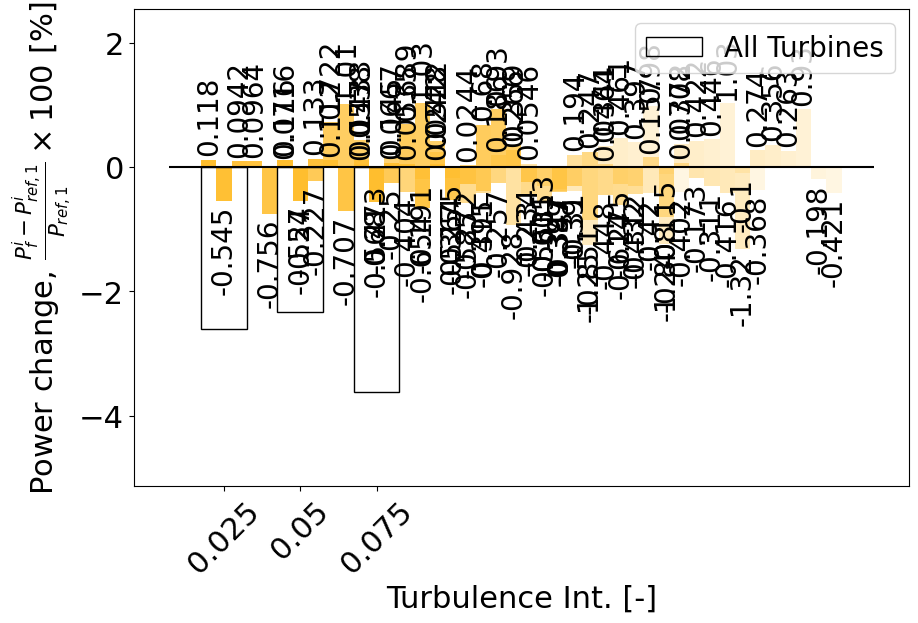

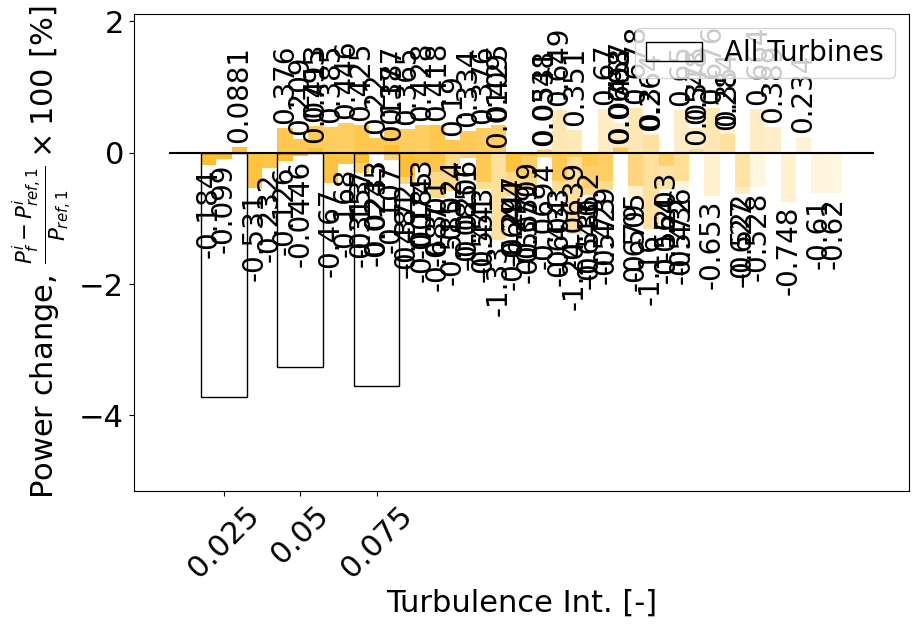

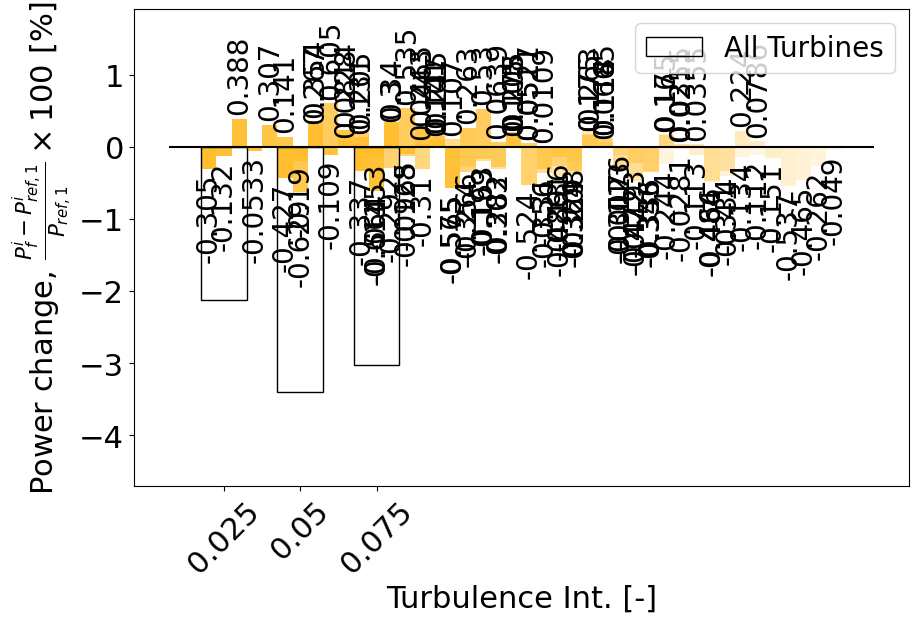

In [30]:
# add QoIs
groupby = ['turb_int']
if Pstochastic_column in case['data']: # this is needed to avoid errors for FLORIS cases, which don't have this variable
    for i, case in enumerate(caselist):

        # expand the power into individual columns
        for j in range(len(case['data']['power'][0])):
            case['data']['power_'+str(j)] = [case['data']['power'].iloc[index][j] for index in range(len(case['data']))]
            case['data'][Pstochastic_column+'_'+str(j)] = [case['data'][Pstochastic_column].iloc[index][j] for index in range(len(case['data']))]  
        case['data']['power_sum'] = [np.sum(case['data']['power'][index]) for index in range(len(case['data']))]   # recalculate power total since previous calculations of reward are normalized
        case['data'][Pstochastic_column+'_sum'] = [np.sum(case['data'][Pstochastic_column][index]) for index in range(len(case['data']))]   # recalculate power total since previous calculations of reward are normalized

        # normalize on FLORIS optimal
        case['data']['r_recalculated'] = (case['data']['power_sum'] - case['data'][Pstochastic_column+'_sum'])/case['data'][Pstochastic_column+'_sum']*100
        for j in range(len(case['data']['power'][0])):
            case['data']['r_recalculated_'+str(j)] = (case['data']['power_'+str(j)] - case['data'][Pstochastic_column+'_'+str(j)])/case['data'][Pstochastic_column+'_sum']*100 #/case['data'][Pstochastic_column+'_'+str(j)]*100
        
        # check that recalculation is consistent with original
        diff = case['data']['r_recalculated'] - case['data']['r']
        max_diff = np.max(np.abs(diff))
        print('Max difference in recalculated reward vs. original reward for case '+str(i)+ ': '+str(max_diff))

        # group
        case['grouped1'] = case['data'].iloc[-avg_length_end:].groupby(by=groupby,as_index=False)['r_recalculated'].mean()
        case['grouped1_indiv'] = [[] for _ in range(len(case['data']['power'][0]))]
        for j in range(len(case['data']['power'][0])):
            case['grouped1_indiv'][j] = case['data'].iloc[-avg_length_end:].groupby(by=groupby,as_index=False)['r_recalculated_'+str(j)].mean()

        ### plot
        values = case['grouped1']
        values_indiv = case['grouped1_indiv']

        # Set the positions of the bars on the x-axis
        categories = [values_indiv[0][groupby].values[j][0] for j in range(len(values_indiv[0]))]
        Turbine_ID = ['Turbine '+str(k) for k in range(len(values_indiv))]
        bar_width = 0.2
        r = [None] * len(Turbine_ID)
        for k in range(len(Turbine_ID)):
            r[k] = [x + bar_width*k for x in np.arange(len(categories))]

        # Create the bar plot
        fig, ax = plt.subplots(figsize=(10, 9))
        for j in range(len(categories)): # loop on TI
            for k in range(len(Turbine_ID)): # loop on turbine number
                alpha = 1-k/(len(Turbine_ID)+4)
                bars = ax.bar(r[k][j], values_indiv[k]['r_recalculated_'+str(k)].iloc[j], color=color, alpha=alpha, width=bar_width, edgecolor='None')#, label=Turbine_ID[k])
                # if j==0:
                #     ax.text(r[k][j]-0.25*bar_width,0.5,Turbine_ID[k],rotation=90,fontsize=fontsize-2)
                ax.bar_label(bars,fmt="{:.3g}",padding=3,fontsize=fontsize-2,rotation=90)
            if j==0:
                bars = ax.bar(r[0][j]+bar_width, values['r_recalculated'].iloc[j], facecolor='none', edgecolor='k', linewidth=1, alpha=1, width=3*bar_width, label='All Turbines')
            else:
                bars = ax.bar(r[0][j]+bar_width, values['r_recalculated'].iloc[j], facecolor='none', edgecolor='k', linewidth=1, alpha=1, width=3*bar_width)

        x_min, x_max = ax.get_xlim()
        ax.hlines(y=0,xmin=x_min,xmax=x_max,color='k',linestyle='-')
        y_min, y_max = ax.get_ylim()
        buffer = 0.25 * (y_max - y_min)
        ax.set_ylim(y_min - buffer, y_max + buffer)

        # Add labels and title
        Pref_label_indiv = Pref_label.replace('}', '}^i')
        ax.set_ylabel(rf'Power change, $\frac{{P_f^i-{Pref_label_indiv}}}{{{Pref_label}}} \times 100$ [$\%$]')
        ax.set_xlabel('Turbulence Int. [-]')
        ax.set_xticks([r + bar_width for r in range(len(categories))])
        ax.set_xticklabels([category for category in categories], rotation=45)  # Rotate labels
        ax.legend(fontsize=fontsize-2)

        plt.subplots_adjust(bottom=0.35)  # Increase bottom margin

        fig.savefig(os.path.join(savefolder,savename_base+'_'+'groupby_turb_int_'+str(i)+'.svg'), format='svg', dpi=100)

In [31]:
# # add QoIs
# groupby = ['wind_dir']
# if Pstochastic_column in case['data']: # this is needed to avoid errors for FLORIS cases, which don't have this variable
#     for i, case in enumerate(caselist):

#         # expand the power into individual columns
#         for j in range(len(case['data']['power'][0])):
#             case['data']['rel_yaw_angles'+str(j)] = [case['data']['rel_yaw_angles'].iloc[index][j] for index in range(len(case['data']))]
#             case['data']['rel_yaw_angles_floris_opt'+str(j)] = [case['data']['rel_yaw_angles_floris_opt'].iloc[index][j] for index in range(len(case['data']))]  

#         # normalize on FLORIS optimal
#         for j in range(len(case['data']['power'][0])):
#             case['data']['r_recalculated_'+str(j)] = (case['data']['rel_yaw_angles'+str(j)] - case['data']['rel_yaw_angles_floris_opt'+str(j)])

#         # group
#         case['grouped1_indiv'] = [[] for _ in range(len(case['data']['power'][0]))]
#         for j in range(len(case['data']['power'][0])):
#             case['grouped1_indiv'][j] = case['data'].iloc[-avg_length_end:].groupby(by=groupby,as_index=False)['r_recalculated_'+str(j)].mean()

#         ### plot
#         values_indiv = case['grouped1_indiv']

#         # Set the positions of the bars on the x-axis
#         categories = [values_indiv[0][groupby].values_indiv[j][0] for j in range(len(values_indiv[0]))]
#         Turbine_ID = ['Turbine '+str(k) for k in range(len(values_indiv))]
#         bar_width = 0.2
#         r = [None] * len(Turbine_ID)
#         for k in range(len(Turbine_ID)):
#             r[k] = [x + bar_width*k for x in np.arange(len(categories))]

#         # Create the bar plot
#         fig, ax = plt.subplots(figsize=(10, 9))
#         for j in range(len(categories)): # loop on wind direction
#             for k in range(len(Turbine_ID)): # loop on turbine number
#                 alpha = 1-k/(len(Turbine_ID)+4)
#                 bars = ax.bar(r[k][j], values_indiv[k]['r_recalculated_'+str(k)].iloc[j], color=color, alpha=alpha, width=bar_width, edgecolor='None', label=Turbine_ID[k])
#                 # if j==0:
#                 #     ax.text(r[k][j]-0.25*bar_width,0.5,Turbine_ID[k],rotation=90,fontsize=fontsize-2)
#                 ax.bar_label(bars,fmt="{:.3g}",padding=3,fontsize=fontsize-2,rotation=90)

#         x_min, x_max = ax.get_xlim()
#         ax.hlines(y=0,xmin=x_min,xmax=x_max,color='k',linestyle='-')
#         y_min, y_max = ax.get_ylim()
#         buffer = 0.25 * (y_max - y_min)
#         ax.set_ylim(y_min - buffer, y_max + buffer)

#         # Add labels and title
#         Pref_label_indiv = Pref_label.replace('}', '}^i')
#         ax.set_ylabel(rf'Relative Yaw Angle, $\gamma^i$ [$^\circ$]')
#         ax.set_xlabel('Wind Direction [$^\circ$]')
#         ax.set_xticks([r + bar_width for r in range(len(categories))])
#         ax.set_xticklabels([category+180 for category in categories], rotation=45)  # Rotate labels

#         plt.subplots_adjust(bottom=0.35)  # Increase bottom margin

#         fig.savefig(os.path.join(savefolder,savename_base+'_'+'groupby_wind_dir_'+str(i)+'_rel_yaw_angles.svg'), format='svg', dpi=100)